# 1. Camera Calibration

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

nx = 9
ny = 6

## Taking multiple images and calibrating to find corners.

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = [] #3d points in real world space
imgpoints = [] #2d points in img plane

## list of all images
Calib_images = glob.glob('camera_cal/calibration*.jpg')
#carimg =cv2.imread(Calib_images[0])
#gray = cv2.cvtColor(carimg, cv2.COLOR_RGB2GRAY)

for calimg in Calib_images:
    caimg = cv2.imread(calimg)
    gray = cv2.cvtColor(caimg, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret== True:
        print(calimg)
        objpoints.append(objp)

        imgpoints.append(corners)
        #img = cv2.drawChessboardCorners(caimg,(nx, ny), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        
ret, mtx,dist,rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print(mtx)
print(dist)


camera_cal\calibration10.jpg
camera_cal\calibration11.jpg
camera_cal\calibration12.jpg
camera_cal\calibration13.jpg
camera_cal\calibration14.jpg
camera_cal\calibration15.jpg
camera_cal\calibration16.jpg
camera_cal\calibration17.jpg
camera_cal\calibration18.jpg
camera_cal\calibration19.jpg
camera_cal\calibration2.jpg
camera_cal\calibration20.jpg
camera_cal\calibration3.jpg
camera_cal\calibration6.jpg
camera_cal\calibration7.jpg
camera_cal\calibration8.jpg
camera_cal\calibration9.jpg
[[  1.15158804e+03   0.00000000e+00   6.66167057e+02]
 [  0.00000000e+00   1.14506859e+03   3.86440204e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.35510339e-01  -7.90388401e-02  -1.28492203e-03   8.25970403e-05
    7.22743173e-02]]


# 2. Defining all the function blocks to run the code in

In [49]:
import matplotlib.image as mpimg
import math

def undistort_img(img, mtx = None, dist = None):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

def perspective_transform(undist_img, src, dst):
    img_size = (undist_img.shape[1], undist_img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped_img = cv2.warpPerspective(undist_img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped_img

def invPerspective_transform(color_warp, dst, src):
    M_inv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (color_warp.shape[1], color_warp.shape[0])) 
    return newwarp

def grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray_2 = ( 0.20*gray[:,:,0] + 0.4*gray[:,:,1] + 0.4*gray[:,:,2]).astype(np.uint8) # 
    return gray_2

def gaussian_blur(img, kernel_size):
    blur_img = cv2.GaussianBlur(img, (kernel_size,kernel_size), 0)
    
    return blur_img

def cannyEdges(img, low_threshold, high_threshold):
    
    edge_img = cv2.Canny(img, low_threshold, high_threshold)
    
    return edge_img


def grayToBinary(gray_img, thresh_min = 50, thresh_max = 150):
    
    #binary_img = np.zeros_like(gray_img)
    _, binary_img = cv2.threshold(gray_img.astype('uint8'), thresh_min, thresh_max, cv2.THRESH_BINARY)
    #binary_img[(gray_img >= thresh_min) & (gray_img <= thresh_max)] = 1
    
    return binary_img


def detect_perspective_points(img, src, low_threshold = 40, high_threshold =150, color = [255, 0, 0],thickness = 10):
    
    rho = 0.5 # The less the value the better
    theta = np.pi/180
    threshold = 10
    min_line_length = 7
    max_line_gap = 15
    
    
    
    gray = grayscale(img)
    blur_img = gaussian_blur(gray, 7)
    edge_img = cannyEdges(blur_img, low_threshold, high_threshold)
    
    lines = cv2.HoughLinesP(edge_img, rho, theta, threshold, min_line_length, max_line_gap)
    
    
    
    angle_min_mag = 25*np.pi/180 
    angle_max_mag = 70*np.pi/180 
    rho_min_diag = 0.1
    rho_max_diag = 0.6 
    
    lane_markers_x = [[],[]]
    lane_markers_y = [[],[]]
    #print(lines)
    diag_len = math.sqrt(img.shape[0]**2 + img.shape[1]**2)
    for line in lines:
        for x1,y1, x2,y2 in line:
            theta = math.atan2(y1-y2, x2-x1)
            rho = ((x1+x2)*math.cos(theta) + (y1+y2)*math.sin(theta))/2
            
            # cv2.line(img, (x1,y1), (x2,y2), color, thickness)
            
            if (abs(theta) >= angle_min_mag and abs(theta) <= angle_max_mag
                and rho >= rho_min_diag*diag_len and rho <= rho_max_diag*diag_len
               ):

                if theta > 0: # positive theta is downward in image space?
                    # Left lane marker
                    i = 0
                else:
                    # Right lane marker
                    i = 1
                lane_markers_x[i].append(x1)
                lane_markers_x[i].append(x2)
                lane_markers_y[i].append(y1)
                lane_markers_y[i].append(y2)
               
   
    p_left  = np.polyfit(lane_markers_x[0], lane_markers_y[0], 1)  
        # Gives out a polinomial function. Y = mx + c => P_left = (m, c) 
    p_right = np.polyfit(lane_markers_x[1], lane_markers_y[1], 1)
        
        
    left_bottom = math.ceil((src[3,1] - p_left[1])/p_left[0])   # x coordinate of Left bottom of the line. 
    right_bottom = math.ceil((src[2,1] - p_right[1])/p_right[0])  
        # x coordinate of the right lane bottom point. y coordinate img.shape[1] known
        
    left_top = math.ceil((src[0,1] - p_left[1])/p_left[0])   # x coordinate of the left lane top point
    right_top = math.ceil((src[1,1] - p_right[1])/p_right[0]) # x coordinate of the Right lane top point
    line_points = np.array([(0, left_bottom,left_top, 0),(right_bottom,img.shape[1], right_top, 0 )], dtype = np.uint8)
    src_points = np.float32([[left_top, src[0,1]], [right_top, src[1,1]], [right_bottom, src[2,1]], [left_bottom, src[3,1]]])
    # Drawing lines for given coordinates
    #for x1,y1, x2,y2 in line_points:
    #    cv2.line(edge_img, (x1,y1), (x2,y2), color, thickness)
    #plt.imshow(edge_img)
    
    return src_points


def hough_lines(img, rho, theta, threshold, min_line_length, max_line_gap):
    lines = cv2.HoughLinesP(img,rho,theta,threshold,np.array([]), min_line_length, max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    lines_img, line_pts = draw_lines(line_img, lines, Past_line_points)
    return line_img

def histogram_xy(edge_img):
    x = edge_img.shape[0]//2
    histogram = np.sum(edge_img[(edge_img.shape[0] - x):,:], axis=0)
    #plt.plot(histogram)
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base_pt = np.argmax(histogram[:midpoint]) 
    ## Finding max point i.e. base of the left lane. left half of histogram
    rightx_base_pt = np.argmax(histogram[midpoint:]) + midpoint  
    ## Finding max point i.e. base of the right lane. Right half of histogram
    
    #print(leftx_base_pt, rightx_base_pt)
    return leftx_base_pt, rightx_base_pt



def windowing(edge_img, leftx_base_pt, rightx_base_pt, nwindows = 9, window_x_margin = 70, min_pix = 30, out_margin = 35):
    # Choose the number of sliding windows
    
    # Set height of windows
    window_height = np.int(edge_img.shape[0]/nwindows)
    print(window_height)
    
    
    current_midPt_left = leftx_base_pt
    current_midPt_right = rightx_base_pt
    
    current_leftLane_lowy = edge_img.shape[0]
    current_rightLane_lowy = edge_img.shape[0]
    nonzero = edge_img.nonzero()
    
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])
    #print(nonzero_x)
    #print(nonzero_y)
    Rectangle_out_img = np.dstack((edge_img, edge_img, edge_img))*255
    maskLane_img = np.zeros_like(Rectangle_out_img)
    # Set minimum number of pixels found to recenter window
    
    
    leftLane_indeces = []
    rightLane_indeces = []
    
    for window in range(nwindows):
        leftLane_Window_lowx =  current_midPt_left - window_x_margin
        leftLane_Window_highx =  current_midPt_left + window_x_margin
        
        rightLane_Window_lowx =  current_midPt_right - window_x_margin
        rightLane_Window_highx =  current_midPt_right + window_x_margin
        
        Window_low_y = edge_img.shape[0] - window_height*window
        Window_high_y = edge_img.shape[0] - window_height*(window + 1)
        
        cv2.rectangle(Rectangle_out_img, (leftLane_Window_lowx, Window_low_y), (leftLane_Window_highx, Window_high_y), (0,230,0), 3)
        cv2.rectangle(Rectangle_out_img, (rightLane_Window_lowx, Window_low_y), (rightLane_Window_highx, Window_high_y), (0,230,0), 3)
        
        good_nonzero_left = ((nonzero_x >= leftLane_Window_lowx) & (nonzero_x < leftLane_Window_highx) & (nonzero_y < Window_low_y) & (nonzero_y >= Window_high_y)).nonzero()[0]
        good_nonzero_right = ((nonzero_x >= rightLane_Window_lowx) & (nonzero_x < rightLane_Window_highx) & (nonzero_y < Window_low_y) & (nonzero_y >= Window_high_y)).nonzero()[0]
        
        leftLane_indeces.append(good_nonzero_left)
        rightLane_indeces.append(good_nonzero_right)
        
        # Updating the X for rectangle boxes
        if len(good_nonzero_left) > min_pix:
            current_midPt_left = np.int(np.mean(nonzero_x[good_nonzero_left]))
            
        if len(good_nonzero_right) > min_pix:
            current_midPt_right = np.int(np.mean(nonzero_x[good_nonzero_right]))
        
    leftLane_indeces = np.concatenate(leftLane_indeces)
    rightLane_indeces = np.concatenate(rightLane_indeces)
    
    leftLane_x = nonzero_x[leftLane_indeces]
    leftLane_y = nonzero_y[leftLane_indeces]
    leftLane_xy = [leftLane_x, leftLane_y]
    
    
    rightLane_x = nonzero_x[rightLane_indeces]
    rightLane_y = nonzero_y[rightLane_indeces]   
    rightLane_xy = [rightLane_x, rightLane_y]
    
    if leftLane_x.size == 0:
        left_polyfit = [0, 0, 150]
    else:
        left_polyfit = np.polyfit(leftLane_y, leftLane_x, 2)  # 2nd order polynomial
    if rightLane_x.size == 0:
        right_polyfit = [0, 0, 850]
    else:
        right_polyfit = np.polyfit(rightLane_y, rightLane_x, 2) # 2nd order polynomial
        
    y_points = np.linspace(0, edge_img.shape[0] - 1, edge_img.shape[0])
    left_x_points = left_polyfit[0]*y_points*y_points + left_polyfit[1]*y_points + left_polyfit[2]
    right_x_points = right_polyfit[0]*y_points*y_points + right_polyfit[1]*y_points + right_polyfit[2]
        
    left_pts = [left_x_points, y_points]
    right_pts = [right_x_points, y_points]
        
    left_line_window1 = np.array([np.transpose(np.vstack([left_x_points - out_margin, y_points]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_x_points + out_margin, y_points])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_x_points - out_margin, y_points]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_x_points + out_margin, y_points])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
    #mask_out_img[nonzero_y[leftLane_indeces], nonzero_x[leftLane_indeces]] = [255, 0, 0]
    #mask_out_img[nonzero_y[rightLane_indeces], nonzero_x[rightLane_indeces]] = [0, 0, 255]
    
    cv2.fillPoly(maskLane_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(maskLane_img, np.int_([right_line_pts]), (0,255, 0))
    
    return maskLane_img, left_pts, right_pts, left_polyfit, right_polyfit, leftLane_xy, rightLane_xy



In [50]:
def margin_fit(edge_img, left_pts, right_pts, prev_left_polyfit, prev_right_polyfit,redoWindow_Reset , x_margin = 70, min_pix = 30, out_margin = 35):
    nonzero = edge_img.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])
    
    left_polyfit = np.polyfit(left_pts[1], left_pts[0], 2)
    right_polyfit = np.polyfit(right_pts[1], right_pts[0], 2)
    
    leftLane_indeces = ((nonzero_x >= (left_polyfit[0]*nonzero_y*nonzero_y + left_polyfit[1]*nonzero_y + left_polyfit[2] - x_margin)) & (nonzero_x < (left_polyfit[0]*nonzero_y*nonzero_y + left_polyfit[1]*nonzero_y + left_polyfit[2] + x_margin)))
    rightLane_indeces = ((nonzero_x >= (right_polyfit[0]*nonzero_y*nonzero_y + right_polyfit[1]*nonzero_y + right_polyfit[2] - x_margin)) & (nonzero_x < (right_polyfit[0]*nonzero_y*nonzero_y + right_polyfit[1]*nonzero_y + right_polyfit[2] + x_margin) ))
    
    leftLane_x = nonzero_x[leftLane_indeces]
    leftLane_y = nonzero_y[leftLane_indeces]
    leftLane_xy = [leftLane_x, leftLane_y]
    
    rightLane_x = nonzero_x[rightLane_indeces]
    rightLane_y = nonzero_y[rightLane_indeces]
    rightLane_xy = [rightLane_x, rightLane_y]
    
    

    if leftLane_x.size == 0:
        left_polyfit = prev_left_polyfit
        margin_fit.offSettFrames = margin_fit.offSettFrames + 1
    else:
        left_polyfit = np.polyfit(leftLane_y, leftLane_x, 2)  # 2nd order polynomial
    if (rightLane_x.size == 0):
        right_polyfit = prev_right_polyfit
        margin_fit.offSettFrames = margin_fit.offSettFrames + 1
    else:
        right_polyfit = np.polyfit(rightLane_y, rightLane_x, 2) # 2nd order polynomial
    
    if not redoWindow_Reset:
        redoWindow = False
    
    if margin_fit.offSettFrames >= 10:
        redoWindow = True
        margin_fit.offSettFrames = 0
    
    y_points = np.linspace(0, edge_img.shape[0] - 1, edge_img.shape[0])
    left_x_points = left_polyfit[0]*y_points*y_points + left_polyfit[1]*y_points + left_polyfit[2]
    right_x_points = right_polyfit[0]*y_points*y_points + right_polyfit[1]*y_points + right_polyfit[2]
    
    ### Visualization
    mask_out_img = np.dstack((edge_img, edge_img, edge_img))*255
    maskLane_img = np.zeros_like(mask_out_img)
    
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_x_points - out_margin, y_points]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_x_points + out_margin, y_points])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_x_points - out_margin, y_points]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_x_points + out_margin, y_points])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    #mask_out_img[nonzero_y[leftLane_indeces], nonzero_x[leftLane_indeces]] = [255, 0, 0]
    #mask_out_img[nonzero_y[rightLane_indeces], nonzero_x[rightLane_indeces]] = [0, 0, 255]
    
    cv2.fillPoly(maskLane_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(maskLane_img, np.int_([right_line_pts]), (0,255, 0))
    
    left_pts = [left_x_points, y_points]
    right_pts = [right_x_points, y_points]
    return maskLane_img, left_pts, right_pts, left_polyfit, right_polyfit, leftLane_xy, rightLane_xy, redoWindow
    
    
margin_fit.offSettFrames = 0

    
def clearStoredData():
    
    process_imagestream.src =  None
    process_imagestream.dst = None
    
    process_imagestream.src_pts = None
    process_imagestream.leftx_base_pt = None
    process_imagestream.rightx_base_pt = None
    
    process_imagestream.left_pts = None
    process_imagestream.right_pts = None
    
    process_imagestream.xDist_lanes = None

# detect offset Position of the vehicle in lanes 
def vehiclePositionOffset(img_size, left_bottom_pt, right_bottom_pt):
    #Assuming camera is placed in the middle of the car
    midpoint = (left_bottom_pt + right_bottom_pt)//2
    car_pos = img_size[0]//2
    offset = (car_pos - midpoint)
    return offset

def radiusOfCurvature(img_size, curve_poly):
    #curve_poly = np.polyfit(y_points*ym_per_pix, x_points*xm_per_pix, 2)
    ypoint =  img_size[1] #taking the max value of y
    rad_curve = (1 + (2*curve_poly[0]*ypoint + curve_poly[1])**2)**1.5/ np.absolute(2*curve_poly[0])
    return rad_curve

def radius_Of_Curvature(x_points, y_points):
    curve_poly = np.polyfit(y_points*ym_per_pix, x_points*xm_per_pix, 2)
    ypoint =  np.max(y_points) #taking the max value of y
    rad_curve = (1 + (2*curve_poly[0]*ypoint + curve_poly[1])**2)**1.5 / np.absolute(2*curve_poly[0])
    return rad_curve

def measureDistanceLanes_x(img_size, left_poly, right_poly):
    
    bottom_x_left = xValFromPoly(left_poly, img_size[1])
    top_x_left = xValFromPoly(left_poly, 0)
    middle_x_left = xValFromPoly(left_poly, img_size[1]//2)
    
    bottom_x_right = xValFromPoly(right_poly, img_size[1])
    top_x_right = xValFromPoly(right_poly, 0)
    middle_x_right = xValFromPoly(right_poly, img_size[1]//2)
    
    bottom_x_dist = bottom_x_right - bottom_x_left
    middle_x_dist = middle_x_right - middle_x_left
    top_x_dist = top_x_right - top_x_left
    
    x_dist = [bottom_x_dist, middle_x_dist, top_x_dist]
    return x_dist

def xValFromPoly(poly, y):
    x = poly[0]*y**2 + poly[1]*y + poly[2]
    return x

def laneSeparationDist_sanity(x_dist, img_size, new_left_poly, new_right_poly):
    bottom_x_left = xValFromPoly(new_left_poly, img_size[1])
    top_x_left = xValFromPoly(new_left_poly, 0)
    middle_x_left = xValFromPoly(new_left_poly, img_size[1]//2)
    
    bottom_x_right = xValFromPoly(new_right_poly, img_size[1])
    top_x_right = xValFromPoly(new_right_poly, 0)
    middle_x_right = xValFromPoly(new_right_poly, img_size[1]//2)
    
    bottom_x_dist = bottom_x_right - bottom_x_left
    middle_x_dist = middle_x_right - middle_x_left
    top_x_dist = top_x_right - top_x_left
    
    # compare saved and new values
    if (bottom_x_dist > (x_dist[0] - x_dist[0]*0.1)) & (bottom_x_dist < (x_dist[0] + x_dist[0]*0.1)) & (middle_x_dist > (x_dist[1] - x_dist[1]*0.15)) & (middle_x_dist < (x_dist[1] + x_dist[1]*0.15)) & (top_x_dist > (x_dist[2] - x_dist[2]*0.15)) & (top_x_dist < (x_dist[2] + x_dist[2]*0.15)):
        s_check = True
        
    else:
        s_check = False
    
    return s_check

In [51]:
## Sanity Filter Check if the lines are paralle. i.e. same distance between lines 

from collections import deque

## Tracking data.
# Define a class to receive the characteristics of each line detection
class Lane():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = deque(maxlen=20) 
        #distance in meters of vehicle center from the line
        self.line_base_pos = deque(maxlen=20) 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.radSanity = False
        self.basePt_x = deque(maxlen=20)
        
        self.poly_0 = deque(maxlen=20)
        self.poly_1 = deque(maxlen=20)
        self.poly_2 = deque(maxlen=20)
        
        
    
    
    def RadiusSanityCheck(self, currentRadius):
        self.radSanity = False
        raddiff = (currentRadius - self.radius_of_curvature)/ self.radius_of_curvature #max change in radius could be 200%
        raddiff = abs(raddiff)
        if raddiff <= 0.5:
            self.radSanity = True
        return self.radSanity
        
        
    
    def cleanLaneData(self):
        self.basePt_x = None
        self.basePt_y = None
        
        self.poly_0 = None
        self.poly_1 = None
        self.poly_2 = None
        
    
    
    #def lookAheadFilter(self):
    #    return


#def sanityCheck():
    ## Check if the measured radius of curvature of left and right curve are similar and are parallel to each other. i.e. if these values seem sane enough
    
    #(R_left - R_right) //  
    
#    return     
    



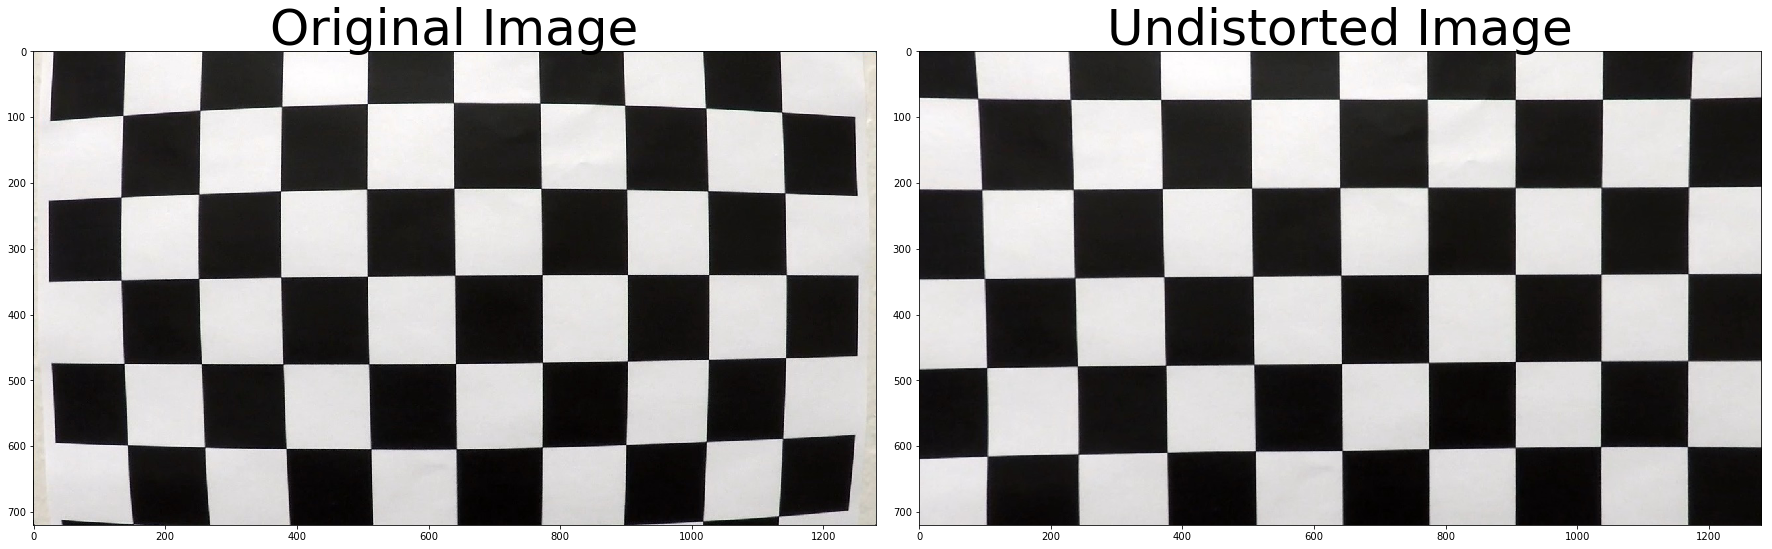

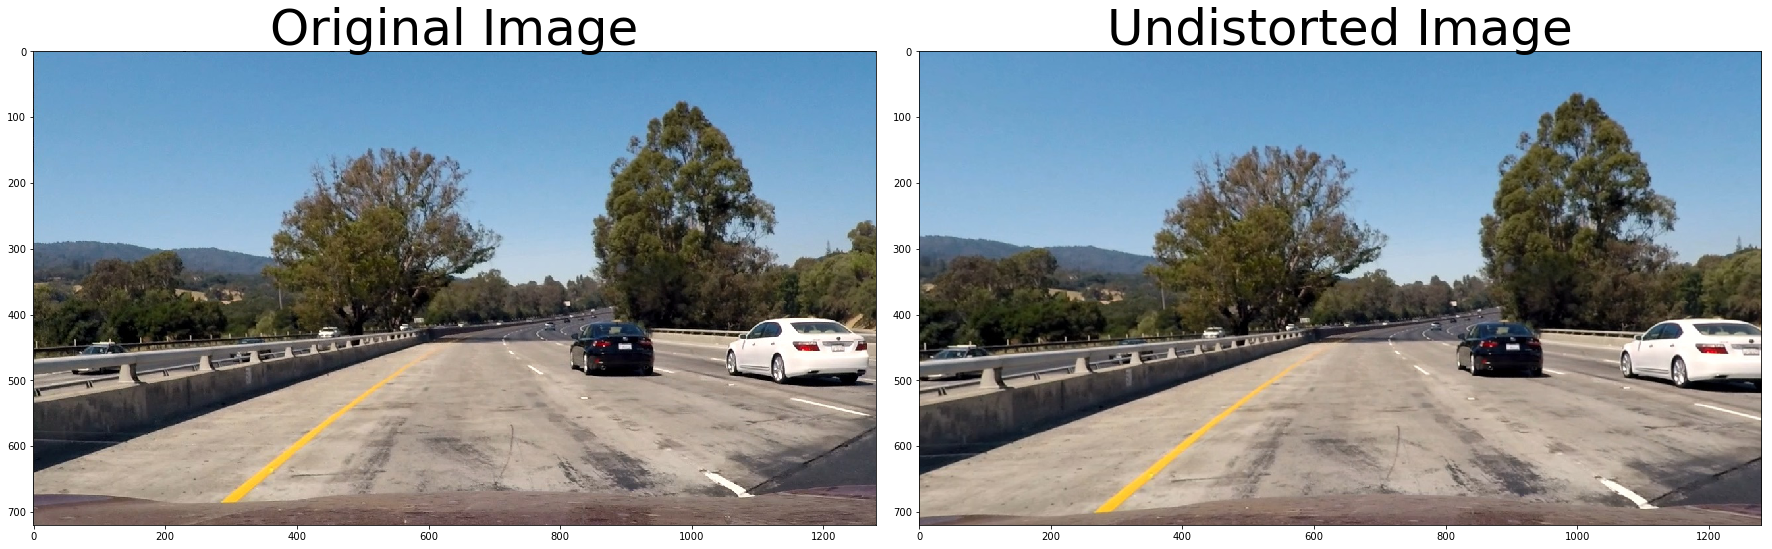

In [9]:


img_cameraMat = mpimg.imread('camera_cal/calibration1.jpg')# test_images/test1.jpg') #

undist_camera_img = undistort_img(img_cameraMat, mtx, dist)
#plt.imshow(undist_img)
#cv2.imshow('undist_img',undist_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_cameraMat)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_camera_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()




img = mpimg.imread('test_images/test1.jpg')

undist_img = undistort_img(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

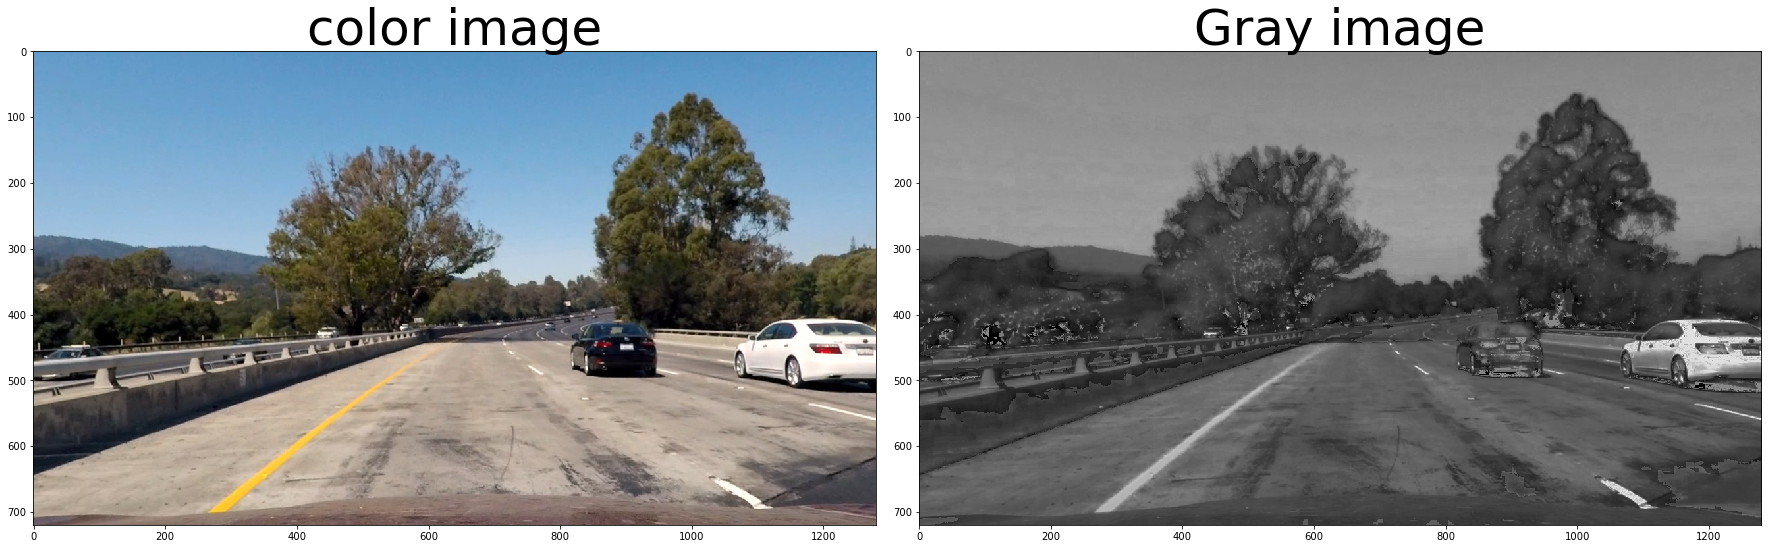

In [69]:
## Applying filter color image to binary image
# HLS filter was applied 
grayimg = grayscale(undist_img)

binaryimg = grayToBinary(grayimg, 120, 200)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('color image', fontsize=50)
ax2.imshow(grayimg, cmap = 'gray')
ax2.set_title('Gray image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

[[  535.   500.]
 [  789.   500.]
 [ 1117.   690.]
 [  274.   700.]]
[ 274.  700.]


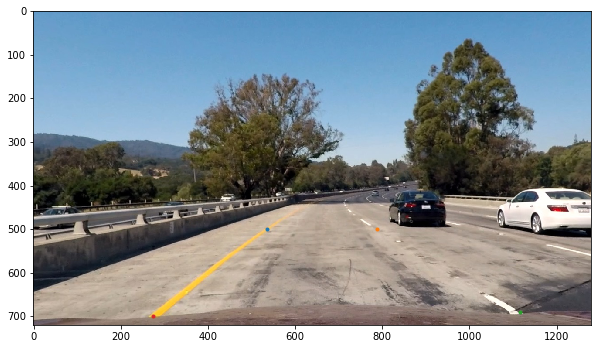

In [34]:
%matplotlib inline

warp_pts = np.float32([[400,500], [900,500], [1150,690], [200,700]])

src_pts =  detect_perspective_points(undist_img, warp_pts)

print(src_pts)

plt.figure(figsize = (10,10))
plt.imshow(undist_img)
plt.plot(src_pts[0, 0], src_pts[0, 1],'.')
plt.plot(src_pts[1, 0], src_pts[1, 1],'.')
plt.plot(src_pts[2, 0], src_pts[2, 1],'.')
plt.plot(src_pts[3, 0], src_pts[3, 1],'.')

[[  561.   480.]
 [  755.   480.]
 [ 1100.   680.]
 [  287.   690.]]


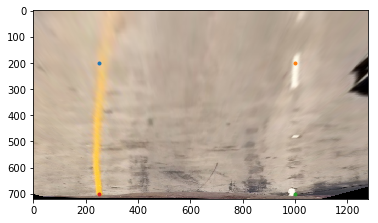

In [64]:
## Perspective transform of the image. 
%matplotlib inline

img_size = (img.shape[1], img.shape[0])
#points in the source image :SRC  to be warped into a rectangle
src =  warp_pts #np.float32([[550,480], [800,500], [1100,670], [250,700]])##[610,440], [720,440], [1150,700], [250,700]])
#points in the source image :SRC  to be warped into a rectangle in destination : DST
dst =  np.float32([[250,200], [1000,200], [1000,700], [250,700]])



src_pts = detect_perspective_points(undist_img, src)
warped = perspective_transform(undist_img, src_pts, dst)
#M = cv2.getPerspectiveTransform(src, dst)
#warped = cv2.warpPerspective(undist_img, M, img_size, flags=cv2.INTER_LINEAR)


print(src_pts)
plt.imshow(warped)
plt.plot(dst[0, 0], dst[0, 1],'.')
plt.plot(dst[1, 0], dst[1, 1],'.')
plt.plot(dst[2, 0], dst[2, 1],'.')
plt.plot(dst[3, 0], dst[3, 1],'.')

(720, 1280)
(720, 1280)


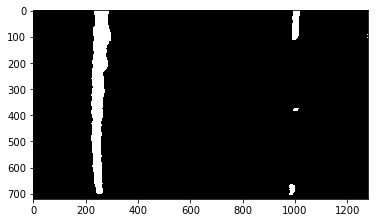

In [36]:
## Into HLS img
low_threshold = 10
high_threshold =150
gray_HLS = grayscale(warped)
blur_img = gaussian_blur(gray_HLS, 7)
im_size = (blur_img.shape[0], blur_img.shape[1])
print(im_size)
edge_img = grayToBinary(blur_img, 120, 200)
plt.imshow(edge_img, cmap='gray')
print(edge_img.shape)

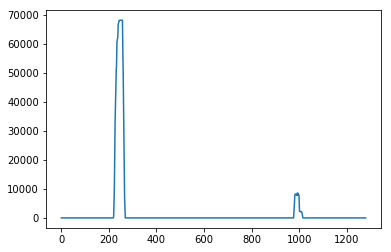

245 992
80
[231 232 233 ..., 984 985 986]
[  0   0   0 ..., 703 703 703]


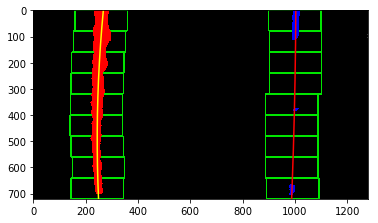

In [39]:
# Taking the histogram of the bottom part of the image. 
#In order to find the base point from which to start sliding window operation
histogram = np.sum(edge_img[(edge_img.shape[0]//2):,:], axis=0)
plt.plot(histogram)
plt.show()

midpoint = np.int(histogram.shape[0]/2)
leftx_base_pt = np.argmax(histogram[:midpoint]) 
## Finding max point i.e. base of the left lane. left half of histogram
rightx_base_pt = np.argmax(histogram[midpoint:]) + midpoint  
## Finding max point i.e. base of the right lane. Right half of histogram

print(leftx_base_pt, rightx_base_pt)


#maskLane_img, left_pts, right_pts, left_polyfit, right_polyfit, leftLane_xy, rightLane_xy = windowing(edge_img, leftx_base_pt, rightx_base_pt)

## Choose the number of sliding windows
nwindows = 9
## Set height of windows
window_height = np.int(edge_img.shape[0]/nwindows)
print(window_height)
window_x_margin = 100

current_midPt_left = leftx_base_pt
current_midPt_right = rightx_base_pt

current_leftLane_lowy = edge_img.shape[0]
current_rightLane_lowy = edge_img.shape[0]

nonzero = edge_img.nonzero()

nonzero_x = np.array(nonzero[1])
nonzero_y = np.array(nonzero[0])
print(nonzero_x)
print(nonzero_y)

Rectangle_out_img = np.dstack((edge_img, edge_img, edge_img))*255

# Set minimum number of pixels found to recenter window
min_pix = 30
plt.imshow(edge_img, cmap = 'gray')

# Drawing windows

leftLane_indeces = []
rightLane_indeces = []

for window in range(nwindows):
    leftLane_Window_lowx =  current_midPt_left - window_x_margin
    leftLane_Window_highx =  current_midPt_left + window_x_margin
    
    rightLane_Window_lowx =  current_midPt_right - window_x_margin
    rightLane_Window_highx =  current_midPt_right + window_x_margin
    
    Window_low_y = edge_img.shape[0] - window_height*window
    Window_high_y = edge_img.shape[0] - window_height*(window + 1)
    
    cv2.rectangle(Rectangle_out_img, (leftLane_Window_lowx, Window_low_y), (leftLane_Window_highx, Window_high_y), (0,230,0), 3)
    cv2.rectangle(Rectangle_out_img, (rightLane_Window_lowx, Window_low_y), (rightLane_Window_highx, Window_high_y), (0,230,0), 3)
    
    
    good_nonzero_left = ((nonzero_x >= leftLane_Window_lowx) & (nonzero_x < leftLane_Window_highx) & (nonzero_y < Window_low_y) & (nonzero_y >= Window_high_y)).nonzero()[0]
    good_nonzero_right = ((nonzero_x >= rightLane_Window_lowx) & (nonzero_x < rightLane_Window_highx) & (nonzero_y < Window_low_y) & (nonzero_y >= Window_high_y)).nonzero()[0]

    leftLane_indeces.append(good_nonzero_left)
    rightLane_indeces.append(good_nonzero_right)
    
    # Updating the X for rectangle boxes
    if len(good_nonzero_left) > min_pix:
        current_midPt_left = np.int(np.mean(nonzero_x[good_nonzero_left]))
        
    if len(good_nonzero_right) > min_pix:
        current_midPt_right = np.int(np.mean(nonzero_x[good_nonzero_right]))
    
leftLane_indeces = np.concatenate(leftLane_indeces)
rightLane_indeces = np.concatenate(rightLane_indeces)



leftLane_x = nonzero_x[leftLane_indeces]
leftLane_y = nonzero_y[leftLane_indeces]

rightLane_x = nonzero_x[rightLane_indeces]
rightLane_y = nonzero_y[rightLane_indeces]

left_polyfit = np.polyfit(leftLane_y, leftLane_x, 2)  # 2nd order polynomial
right_polyfit = np.polyfit(rightLane_y, rightLane_x, 2) # 2nd order polynomial

y_points = np.linspace(0, edge_img.shape[0] - 1, edge_img.shape[0])
left_x_points = left_polyfit[0]*y_points*y_points + left_polyfit[1]*y_points + left_polyfit[2]
right_x_points = right_polyfit[0]*y_points*y_points + right_polyfit[1]*y_points + right_polyfit[2]


Rectangle_out_img[nonzero_y[leftLane_indeces], nonzero_x[leftLane_indeces]] = [255, 0, 0]
Rectangle_out_img[nonzero_y[rightLane_indeces], nonzero_x[rightLane_indeces]] = [0, 0, 255]

plt.imshow(Rectangle_out_img)
plt.plot(left_x_points, y_points, color='yellow')
plt.plot(right_x_points, y_points, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

(720, 0)

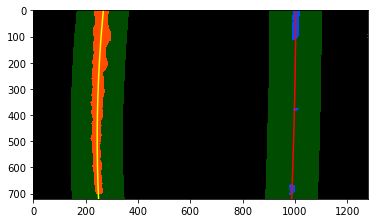

In [40]:
## Dont need the sliding window lines any more

nonzero = edge_img.nonzero()

nonzero_x = np.array(nonzero[1])
nonzero_y = np.array(nonzero[0])

leftLane_indeces = ((nonzero_x >= (left_polyfit[0]*nonzero_y*nonzero_y + left_polyfit[1]*nonzero_y + left_polyfit[2] - window_x_margin)) & (nonzero_x < (left_polyfit[0]*nonzero_y*nonzero_y + left_polyfit[1]*nonzero_y + left_polyfit[2] + window_x_margin)))
rightLane_indeces = ((nonzero_x >= (right_polyfit[0]*nonzero_y*nonzero_y + right_polyfit[1]*nonzero_y + right_polyfit[2] - window_x_margin)) & (nonzero_x < (right_polyfit[0]*nonzero_y*nonzero_y + right_polyfit[1]*nonzero_y + right_polyfit[2] + window_x_margin) ))

leftLane_x = nonzero_x[leftLane_indeces]
leftLane_y = nonzero_y[leftLane_indeces]

rightLane_x = nonzero_x[rightLane_indeces]
rightLane_y = nonzero_y[rightLane_indeces]

left_polyfit = np.polyfit(leftLane_y, leftLane_x, 2)  # 2nd order polynomial
right_polyfit = np.polyfit(rightLane_y, rightLane_x, 2) # 2nd order polynomial

y_points = np.linspace(0, edge_img.shape[0] - 1, edge_img.shape[0])
left_x_points = left_polyfit[0]*y_points*y_points + left_polyfit[1]*y_points + left_polyfit[2]
right_x_points = right_polyfit[0]*y_points*y_points + right_polyfit[1]*y_points + right_polyfit[2]

### Visualization
mask_out_img = np.dstack((edge_img, edge_img, edge_img))*255
maskLane_img = np.zeros_like(mask_out_img)

left_line_window1 = np.array([np.transpose(np.vstack([left_x_points - window_x_margin, y_points]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_x_points + window_x_margin, y_points])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_x_points - window_x_margin, y_points]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_x_points + window_x_margin, y_points])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

mask_out_img[nonzero_y[leftLane_indeces], nonzero_x[leftLane_indeces]] = [255, 0, 0]
mask_out_img[nonzero_y[rightLane_indeces], nonzero_x[rightLane_indeces]] = [0, 0, 255]

cv2.fillPoly(maskLane_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(maskLane_img, np.int_([right_line_pts]), (0,255, 0))

lane_out_img = cv2.addWeighted(mask_out_img, 1, maskLane_img, 0.3, 0)

plt.imshow(lane_out_img)
plt.plot(left_x_points, y_points, color='yellow')
plt.plot(right_x_points, y_points, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [57]:
#Radius of curvature 
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

Left_Lane = Lane()
Right_Lane = Lane()

def process_imagestream(image):  
    %matplotlib inline
    
    #warp_pts = np.float32([[550,480], [800,500], [1100,670], [250,700]])
    img_size = (image.shape[1], image.shape[0])
    #points in the source image :SRC  to be warped into a rectangle
    #process_imagestream.src =  warp_pts #np.float32([[550,480], [800,500], [1100,670], [250,700]])##[610,440], [720,440], [1150,700], [250,700]])
    #points in the source image :SRC  to be warped into a rectangle in destination : DST
    mtx = process_imagestream.mtx
    dist = process_imagestream.dist
    undist_img = undistort_img(image, mtx, dist)
    if process_imagestream.src is None:
        src_pts = detect_perspective_points(undist_img, process_imagestream.initCalibPts)
        process_imagestream.src_pts = src_pts
        process_imagestream.src = src_pts
        
    src = process_imagestream.src
    dst = process_imagestream.dst
    warped = perspective_transform(undist_img, src, dst)
    low_threshold = 10
    high_threshold =150
    gray_HLS = grayscale(warped)
    blur_img = gaussian_blur(gray_HLS, 7)
    im_size = (blur_img.shape[0], blur_img.shape[1])
    print(im_size)
    edge_img = grayToBinary(blur_img, 120, 200)
    plt.imshow(edge_img, cmap='gray')
    
    
    left_pts = process_imagestream.left_pts
    right_pts = process_imagestream.right_pts
    
    if (process_imagestream.leftx_base_pt is None) or (process_imagestream.rightx_base_pt is None) or (process_imagestream.redoWindow is True): ##or (process_imagestream.left_pts is None) or (process_imagestream.right_pts is None):
        leftx_base_pt, rightx_base_pt = histogram_xy(edge_img)
        process_imagestream.leftx_base_pt = leftx_base_pt
        process_imagestream.rightx_base_pt = rightx_base_pt
        maskLane_img, left_pts, right_pts, left_poly, right_poly, leftLane_xy, rightLane_xy = windowing(edge_img, leftx_base_pt, rightx_base_pt)
        process_imagestream.xDist_lanes = measureDistanceLanes_x(img_size, left_poly, right_poly)
        process_imagestream.redoWindow = False
        
    else: 
        maskLane_img, left_pts, right_pts, left_poly, right_poly,leftLane_xy, rightLane_xy, process_imagestream.redoWindow = margin_fit(edge_img, left_pts, right_pts, Left_Lane.current_fit, Right_Lane.current_fit, process_imagestream.redoWindow)
    
    left_bottom_x = left_poly[0]*img_size[1]**2 + left_poly[1]*img_size[1] + left_poly[2]
    right_bottom_x = right_poly[0]*img_size[1]**2 + right_poly[1]*img_size[1] + right_poly[2]
    
    print(process_imagestream.xDist_lanes)
    #sanityCheck()
    
    distSanityCheck = laneSeparationDist_sanity(process_imagestream.xDist_lanes, img_size, left_poly, right_poly)
    #if (left_pts[] is None) or (right_pts is None):
        
    if (distSanityCheck == False) or (leftLane_xy[0].size == 0) or (rightLane_xy[0].size == 0):  #
        process_imagestream.redoWindow = True
        
        if leftLane_xy[0].size == 0:
            ### using the weighted average of previous stored data 
            left_poly = Left_Lane.current_fit 
            left_pts = [Left_Lane.allx, Left_Lane.ally]
        
        if rightLane_xy[0].size == 0:
            ### using the weighted average of previous stored data 
            right_poly = Right_Lane.current_fit 
            right_pts = [Right_Lane.allx, Right_Lane.ally]
        
        
    ### Loading data into Left_Lane object
    Left_Lane.poly_0.append(left_poly[0])
    Left_Lane.poly_1.append(left_poly[1])
    Left_Lane.poly_2.append(left_poly[2])
    Left_Lane.basePt_x.append(left_bottom_x)   
    Left_Lane.current_fit = left_poly  # current polynomial     
    Left_Lane.allx = left_pts[0]
    Left_Lane.ally = left_pts[1]

    
    ### Loading data into Right_Lane object
    Right_Lane.poly_0.append(right_poly[0])
    Right_Lane.poly_1.append(right_poly[1])
    Right_Lane.poly_2.append(right_poly[2])
    Right_Lane.basePt_x.append(right_bottom_x)   
    Right_Lane.current_fit = right_poly  # current polynomial     
    Right_Lane.allx = right_pts[0]
    Right_Lane.ally = right_pts[1]
    
    
    
    
    process_imagestream.left_pts = left_pts
    process_imagestream.right_pts = right_pts
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(edge_img).astype(np.uint8)
    color_warp = np.dstack((edge_img, edge_img, edge_img))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack(left_pts))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack(right_pts)))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 70)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    unwarped_img = invPerspective_transform(color_warp, dst, src)
    out_img = cv2.addWeighted(undist_img, 1, unwarped_img, 0.3, 0)
    
    
    left_rad = radius_Of_Curvature(left_pts[0], left_pts[1]) #radiusOfCurvature(img_size, left_poly) #
    right_rad = radius_Of_Curvature(right_pts[0], right_pts[1]) #radiusOfCurvature(img_size, right_poly) #
    
    Left_Lane.radius_of_curvature.append(left_rad)
    Right_Lane.radius_of_curvature.append(right_rad)
    
    pos_offset = xm_per_pix*vehiclePositionOffset(img_size, left_bottom_x, right_bottom_x)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(out_img,'Vehicle position : %.2f m %s of center'%(abs(pos_offset), 'left' if pos_offset < 0 else 'right'),(50,110), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img,'Left radius of curvature  = %.2f m'%(left_rad),(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img,'Right radius of curvature = %.2f m'%(right_rad),(50,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    
    plt.figure(figsize = (10,10))
    #plt.imshow(out_img)
    plt.imshow(out_img)
    #plt.plot(src[0,0], src[0,1],'.')
    #plt.plot(src[1,0], src[1,1],'.')
    #plt.plot(src[2,0], src[2,1],'.')
    #plt.plot(src[3,0], src[3,1],'.')
    return out_img
warp_pts = np.float32([[550,480], [800,480], [1100,670], [250,670]])
process_imagestream.initCalibPts =  warp_pts
process_imagestream.src =  None
process_imagestream.dst =  np.float32([[250,200], [1000,200], [1000,670], [250,670]])
process_imagestream.mtx = mtx 
process_imagestream.dist = dist

process_imagestream.src_pts = None
process_imagestream.leftx_base_pt = None
process_imagestream.rightx_base_pt = None

process_imagestream.left_pts = None
process_imagestream.right_pts = None
process_imagestream.redoWindow = False
process_imagestream.xDist_lanes = None

(720, 1280)
80
[747.9929157849449, 748.06976952965499, 762.21342265421299]
(720, 1280)
80
[747.91261652148216, 740.90932171596864, 725.34264912724927]


array([[[ 91, 138, 184],
        [ 91, 138, 184],
        [ 90, 137, 183],
        ..., 
        [ 90,  86,  75],
        [ 94,  89,  78],
        [ 95,  90,  78]],

       [[ 91, 138, 184],
        [ 91, 138, 184],
        [ 90, 137, 183],
        ..., 
        [ 82,  76,  63],
        [ 86,  80,  66],
        [ 85,  79,  65]],

       [[ 90, 137, 183],
        [ 90, 137, 183],
        [ 90, 137, 183],
        ..., 
        [ 74,  69,  51],
        [ 79,  73,  55],
        [ 76,  71,  52]],

       ..., 
       [[ 76,  56,  59],
        [ 76,  55,  58],
        [ 75,  55,  57],
        ..., 
        [109,  86,  68],
        [113,  90,  72],
        [115,  92,  74]],

       [[ 75,  54,  55],
        [ 75,  55,  55],
        [ 76,  55,  56],
        ..., 
        [106,  83,  65],
        [108,  85,  67],
        [112,  89,  71]],

       [[ 76,  55,  53],
        [ 77,  56,  54],
        [ 78,  57,  55],
        ..., 
        [110,  87,  69],
        [111,  88,  70],
        [112,  89,

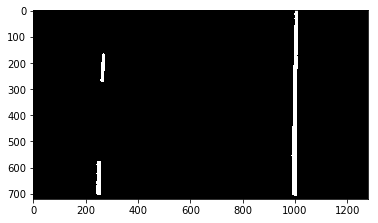

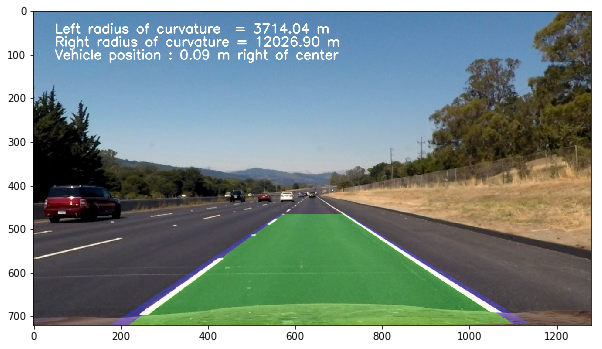

In [45]:
## Feed an image and see if it works
img = mpimg.imread('test_images/straight_lines1.jpg')
process_imagestream(img)

clearStoredData()
warp_pts = np.float32([[500,480], [800,480], [1100,680], [250,690]])
process_imagestream.initCalibPts =  warp_pts
process_imagestream.dst =  np.float32([[250,200], [1000,200], [1000,700], [250,700]])

img_2 = mpimg.imread('test_images/straight_lines2.jpg')
process_imagestream(img_2)

In [56]:
## Testing video
import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import *
from IPython.display import HTML



In [58]:
# Project video to be processed

clearStoredData()
warp_pts = np.float32([[400,480], [840,480], [1100,680], [250,690]])
process_imagestream.initCalibPts =  warp_pts
process_imagestream.dst =  np.float32([[250,200], [1000,200], [1000,700], [250,700]])


white_output = 'WhYellowLanes_out.mp4'

whiteLanesVid = VideoFileClip("project_video.mp4") # challenge_video
whiteVid_Clip = whiteLanesVid.fl_image(lambda i: process_imagestream(i))
%time whiteVid_Clip.write_videofile(white_output, audio=False)

OSError: [WinError 6] The handle is invalid

In [1]:
# Append video of main challenge in the jupyter noatbook

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

NameError: name 'HTML' is not defined

In [66]:
## Extra challenge

clearStoredData()
warp_pts = np.float32([[400,460], [890,460], [1200,690], [200,690]])
process_imagestream.initCalibPts =  warp_pts
process_imagestream.dst =  np.float32([[265,200], [990,200], [1000,700], [250,700]])


dist_output = 'DistLanes_out.mp4'

yellowLanesVid = VideoFileClip("challenge_video.mp4") # challenge_video
yellowVid_Clip = yellowLanesVid.fl_image(lambda i: process_imagestream(1))
%time yellowVid_Clip.write_videofile(dist_output, audio=False)

AttributeError: 'int' object has no attribute 'shape'

In [2]:
# Append video of extra challenge in the jupyter noatbook

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(dist_output))

NameError: name 'HTML' is not defined